In [1]:
import thesis

import matplotlib.pyplot as plt
import matplotlib.cm as cmap
cm = cmap.inferno

In [32]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import theano
import theano.tensor as tt
import theano.tensor.nlinalg
import sys
#sys.path.insert(0, "../../..")
import pymc3 as pm

/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/heron-stable/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import pandas as pd

In [4]:
hills = pd.read_csv("arrochar.csv")

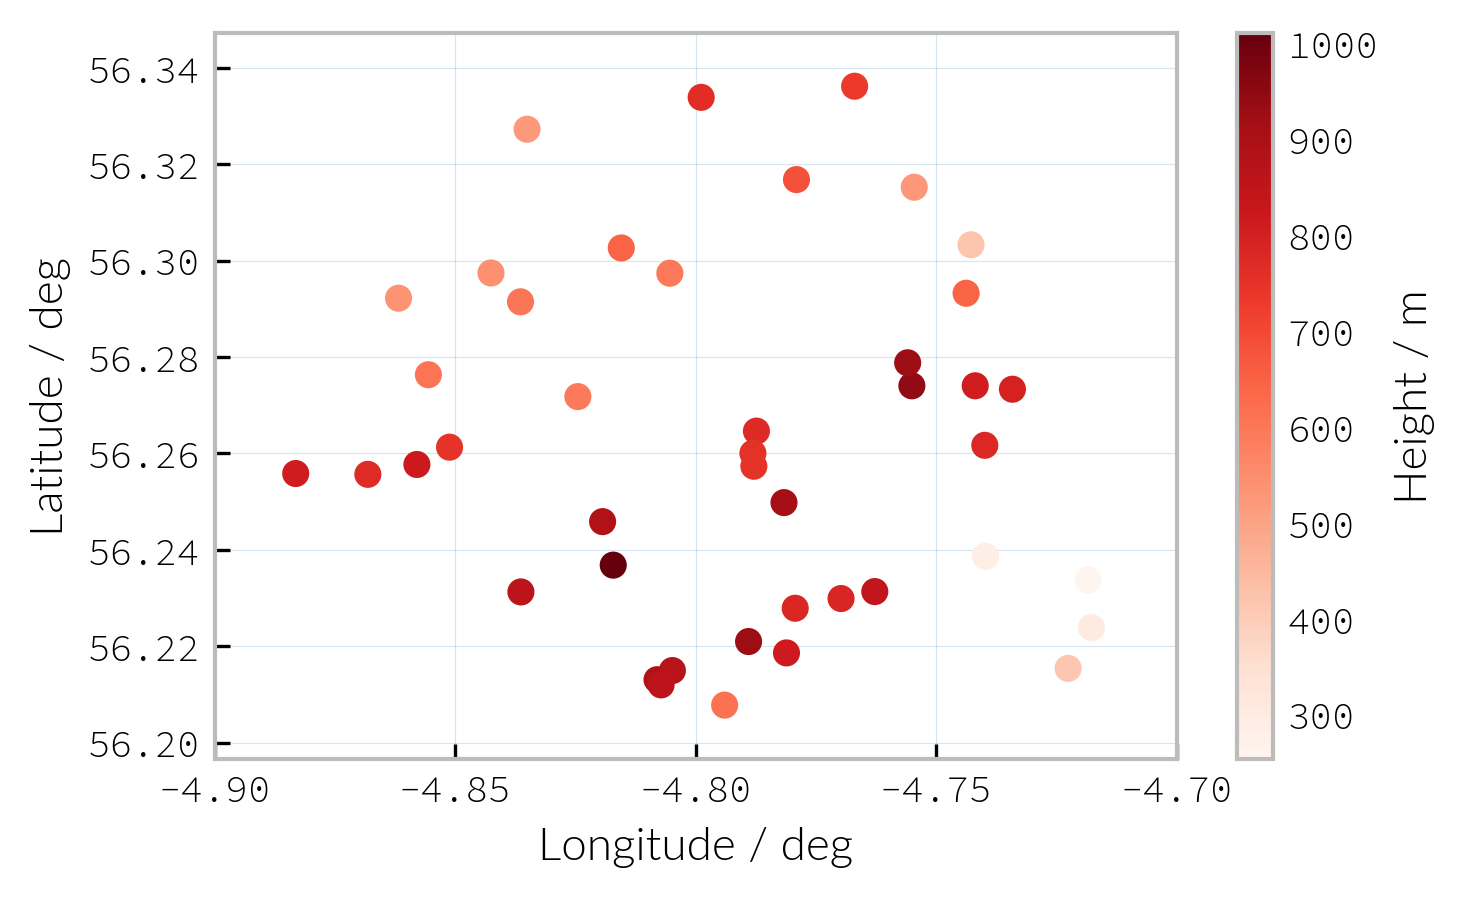

In [208]:
f, ax = plt.subplots(1,1, figsize=thesis.figsize, dpi=300)
scatter = ax.scatter(hills['lon'], hills['lat'], c=hills['height'], cmap='Reds')#, 'o', color='k')
#for i, txt in enumerate(n):
#plt.annotate(np.array(alps['height']), (np.array(alps['lat']), np.array(alps['lon'])))

ax.set_xlabel("Longitude / deg")#, fontdict=lato)
ax.set_ylabel("Latitude / deg")#, fontdict=lato)

cbar = f.colorbar(scatter)
cbar.set_label("Height / m")

ax.set_xticks([-4.9, -4.85, -4.8, -4.75, -4.7])

f = thesis.thesisify(f);

f.savefig("../../figures/gp/arrochar-heights.pdf")

In [99]:
from matplotlib import font_manager

In [100]:
ssp_ticks = {'family': 'Source Code Pro',
             'weight': 'light',
             'size': 7,
}

ticks_font_small = font_manager.FontProperties(**ssp_ticks)

In [198]:
import matplotlib.patheffects as path_effects
def plot_map(mu, var, hills, min=0, ax = None, label=False, contour_interval=10, plot_var=False):
    new = False
    if not ax:
        new = True
        f, ax = plt.subplots(1,1, figsize=thesis.figsize, dpi=300)
    levels = np.arange(min, 1100, contour_interval)

    if plot_var:
        var = ax.imshow(var.reshape(150,150), 
                  extent=[lons.min(), lons.max(), lats.min(), lats.max()], 
                  alpha=0.7, 
                  #vmin=-200, vmax=1100,
                  aspect='auto',
                  cmap='magma', origin='lower')

    
    # np.mod(np.arange(len(levels)),5)!=0
    if not plot_var:
        contour_color = '#ff8959'
        contour_alpha = 0.75
    else:
        contour_color = "#FFFFFF"
        contour_alpha = 0.3
    CS =ax.contour(lons, lats, (mu.reshape(150,150)), levels[levels%50!=0], linewidths=.5, colors=contour_color, alpha=contour_alpha, zorder=1)
    CS = ax.contour(lons, lats, (mu.reshape(150,150)), levels[levels%50==0], linewidths=1, colors=contour_color, alpha=contour_alpha, zorder=1)
    
    c_labels = ax.clabel(CS, levels[levels%100==0], fontsize=5, inline=1, fmt="%.0f")


    for label in c_labels:
        label.set_font_properties(ticks_font_small)

        
    
    ax.plot(hills['lon'], hills['lat'], 'o', markerfacecolor='k', markeredgecolor='w', zorder=98, markersize=3)
    
    if new == True or label == True:
        for hill in hills.iterrows():
            text = ax.text(0.0035+hill[1]['lon'], hill[1]['lat']-0.0015, int(hill[1]['height']), 
                           fontsize=4, zorder=99, fontdict=thesis.ssp_legend)
            text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='white'),
                               path_effects.Normal()])
            if hill[1]['height'] > 880:
                #print hill[1]['lon'], hill[1]['lat']
                
                text = ax.text(-0.00065+hill[1]['lon'], hill[1]['lat']-0.0003, hill[1]['name'], 
                              fontsize=5, fontdict=thesis.lato, zorder=999, ha="right")
                #text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                #               path_effects.Normal()])
        #plt.colorbar()

    if new:
        ax.set_xlabel("Longitude / deg")
        ax.set_ylabel("Latitude / deg")
        
    #if not new:
    #    ax.set_yticks(ax.get_ytick_labels()[1:-1])

    if new:
        for ax in f.axes:
            #ax.get_yaxis().get_major_formatter()._useMathText=False
            #ax.get_xaxis().get_major_formatter()._useMathText=False
            for label in ax.get_xticklabels():
                label.set_fontproperties(thesis.ticks_font)
            ax.set_xlabel(ax.get_xlabel(), fontdict=thesis.lato)  
            ax.xaxis.get_offset_text().set_fontproperties(thesis.ticks_font)
            for label in ax.get_yticklabels():
                label.set_fontproperties(thesis.ticks_font)
            ax.set_ylabel(ax.get_ylabel(), fontdict=thesis.lato) 
            ax.yaxis.get_offset_text().set_fontproperties(thesis.ticks_font)

            
            
    if new:
        #thesis.thesisify(f);

        #f.tight_layout()
        return f
    else:
        return ax
#f.savefig("../../figures/gp/arrochar-alps.pdf")

In [8]:
lons = np.linspace(-4.85, -4.70, 20)
lats = np.linspace(56.20, 56.28, 20)
points = np.transpose([np.tile(lons, len(lats)), np.repeat(lats, len(lons))])

In [24]:
with pm.Model() as model:
    
    amp = pm.Normal("amplitude", 1, 1)
    ls = [0.012, 0.012] #
    ls = pm.Normal("metric", mu=[0.012, 0.012], sd=1, shape=2) #pm.Gamma("metric", alpha=3, beta=0.5, shape=2)
    #ls = pm.Gamma("metric", alpha=.03, beta=0.015, shape=2)
    #period = pm.Gamma("period", alpha=1, beta=0.5)
    alpha = pm.Gamma("alpha", alpha=5, beta=.5, shape=1)
    # Specify the covariance function.
    cov_func = amp * pm.gp.cov.RatQuad(2, ls=ls, alpha=alpha) #+ pm.gp.cov.WhiteNoise(1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # 
    sigma = pm.Normal("sigma", 0.1, 0.001)
    y_ = gp.marginal_likelihood("y", X=np.vstack([hills['lon'], hills['lat']]).T, y=np.array(hills['height']), noise=sigma)

In [10]:
with model:
    mp = pm.find_MAP()

/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/heron-stable/lib/python2.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -17,796, ||grad|| = 1,003.1: 100%|██████████| 94/94 [00:00<00:00, 143.64it/s]         


In [11]:
lons = np.linspace(-4.9, -4.70, 150)
lats = np.linspace(56.20, 56.35, 150)
points = np.transpose([np.tile(lons, len(lats)), np.repeat(lats, len(lons))])

In [12]:
with model:
    mu_rq, var_rq = gp.predict(points, point=mp, diag=True)
    sd_rq = np.sqrt(var_rq)

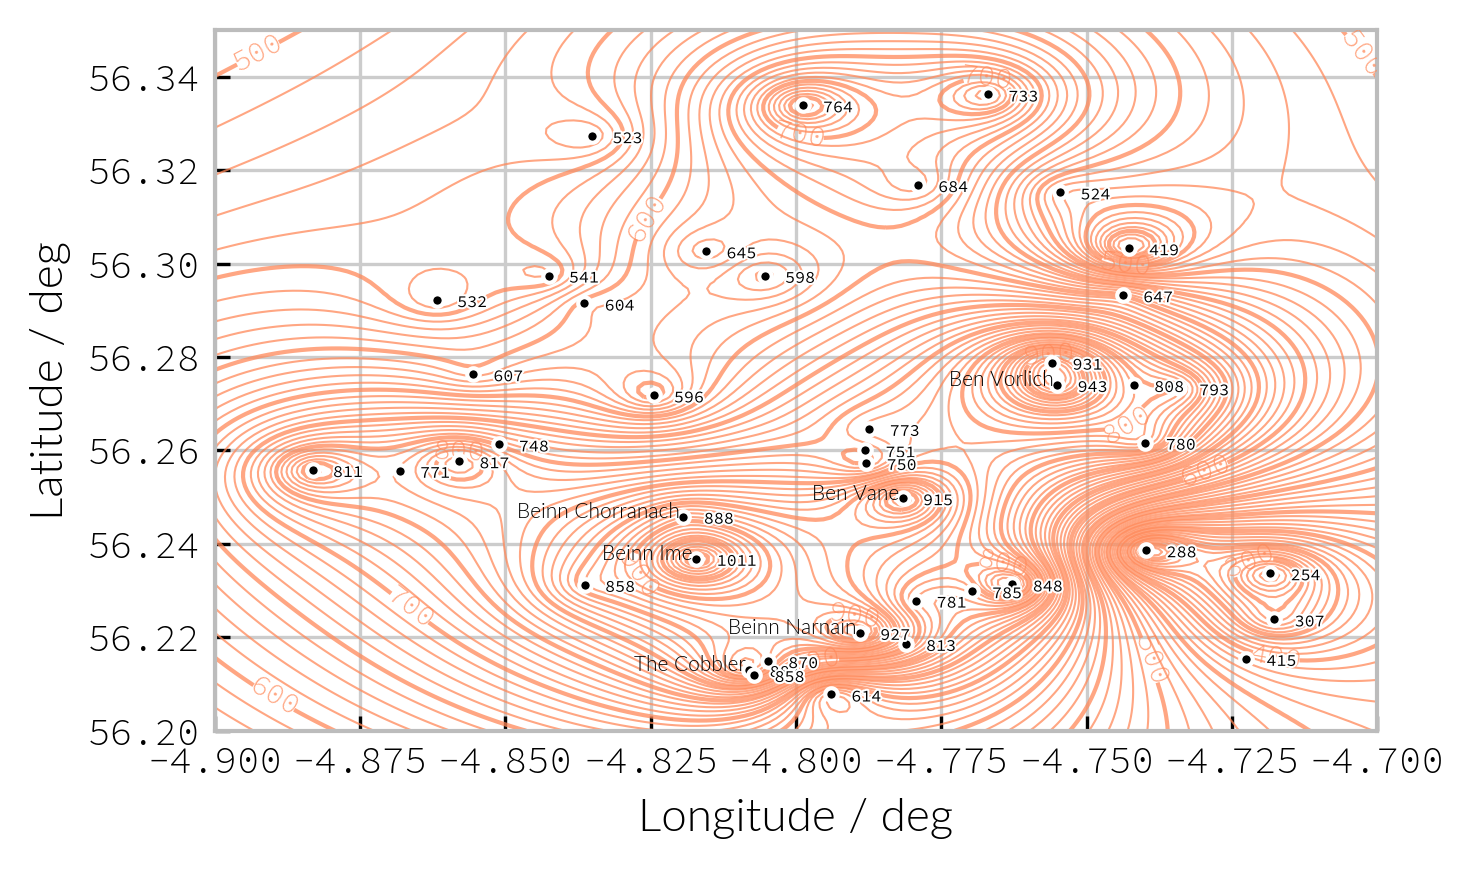

In [131]:
f = plot_map(mu_rq, sd_rq, hills,  min=260, contour_interval=10, label=True);
#f = thesis.thesisify(f, height=1)



f.savefig("../../figures/gp/arrochar-alps.pdf")

In [132]:
with pm.Model() as model:

    amp = pm.Normal("amplitude", 1, 1)
    ls = pm.HalfCauchy("metric", [0.012, 0.012], shape=2)
    # Specify the covariance function.
    cov_func = amp * pm.gp.cov.ExpQuad(2, ls=ls) #, alpha=alpha) #+ pm.gp.cov.WhiteNoise(1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # 
    sigma = pm.Normal("sigma", 0.1, 0.001)
    y_ = gp.marginal_likelihood("y", X=np.vstack([hills['lon'], hills['lat']]).T, y=np.array(hills['height']), noise=sigma)
    mp = pm.find_MAP()

with model:
    mu_eq, var_eq = gp.predict(points, point=mp, diag=True)
    sd_eq = np.sqrt(var_eq)

logp = -40,315, ||grad|| = 6.9474: 100%|██████████| 89/89 [00:00<00:00, 334.87it/s]      


In [135]:
with pm.Model() as model:

    amp = pm.Normal("amplitude", 1, 1)
    ls = pm.HalfCauchy("metric", [5,5], shape=2)
    # Specify the covariance function.
    cov_func = amp * pm.gp.cov.Exponential(2, ls_inv=ls) #, alpha=alpha) #+ pm.gp.cov.WhiteNoise(1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # 
    sigma = pm.Normal("sigma", 0.1, 0.001)
    y_ = gp.marginal_likelihood("y", X=np.vstack([hills['lon'], hills['lat']]).T, y=np.array(hills['height']), noise=sigma)
    mp = pm.find_MAP()

with model:
    mu_ex, var_ex = gp.predict(points, point=mp, diag=True)
    sd_ex = np.sqrt(var_ex)

logp = -20,053, ||grad|| = 19.934: 100%|██████████| 40/40 [00:00<00:00, 335.42it/s]      


In [124]:
with pm.Model() as model:

    amp = pm.Normal("amplitude", 1, 1)
    ls = pm.HalfCauchy("metric", [1,1], shape=2)
    # Specify the covariance function.
    cov_func = amp * pm.gp.cov.Matern52(2, ls=ls) #, alpha=alpha) #+ pm.gp.cov.WhiteNoise(1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # 
    sigma = pm.Normal("sigma", 0.1, 0.001)
    y_ = gp.marginal_likelihood("y", X=np.vstack([hills['lon'], hills['lat']]).T, y=np.array(hills['height']), noise=sigma)
    mp = pm.find_MAP()

with model:
    mu_mat, var_mat = gp.predict(points, point=mp, diag=True)
    sd_mat = np.sqrt(var_mat)

logp = -1.6908e+05, ||grad|| = 5.2342e+05: 100%|██████████| 63/63 [00:00<00:00, 191.88it/s]  


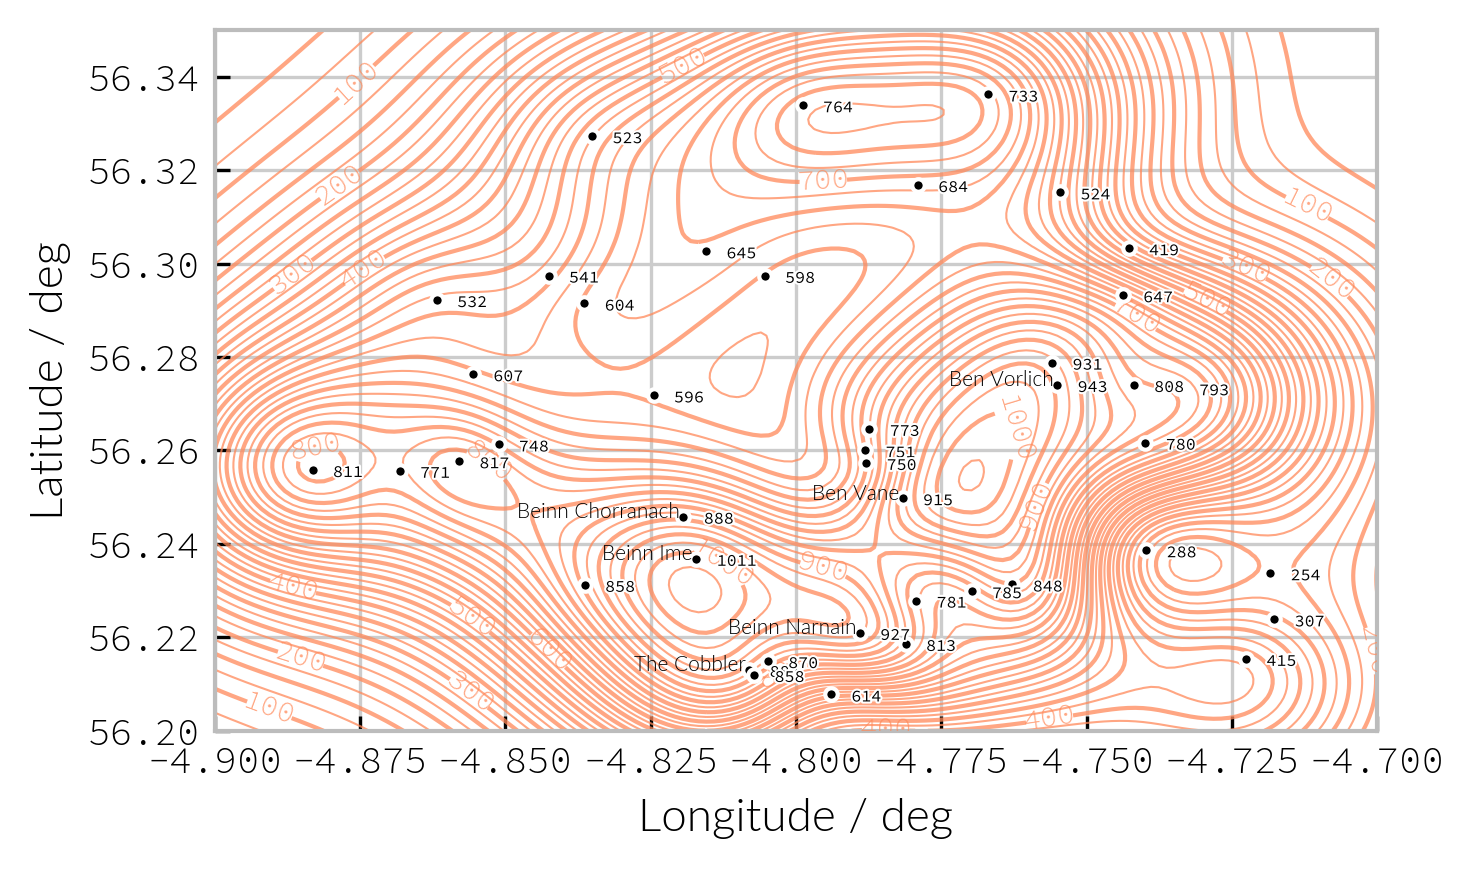

In [137]:
plot_map(mu_mat, sd_mat, hills, min=50,contour_interval=25);

In [169]:
ax.flat

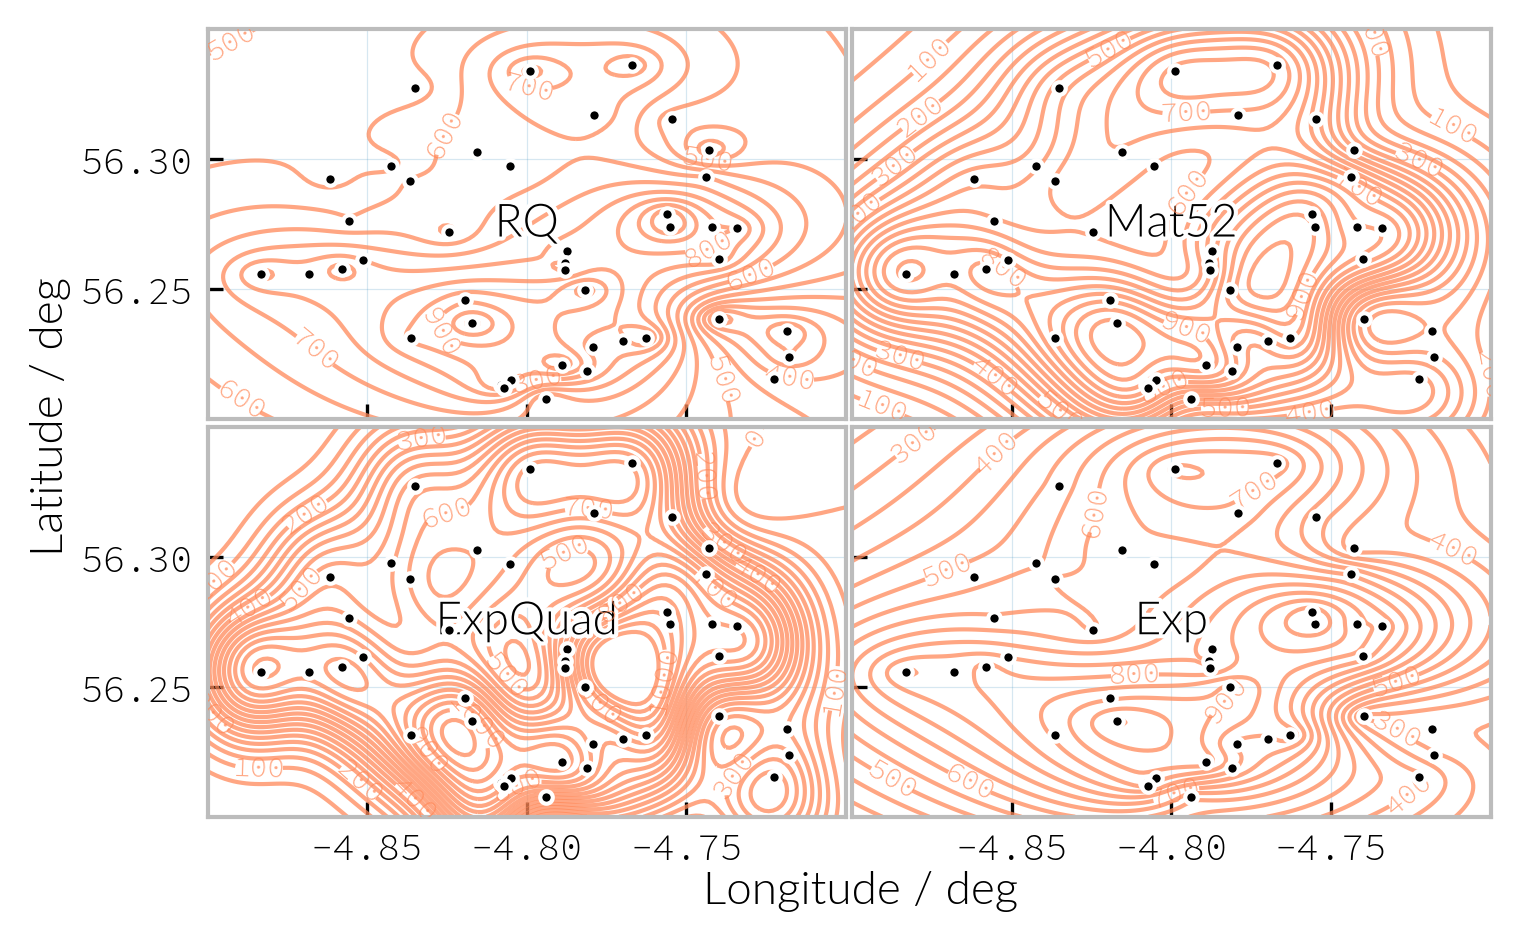

In [202]:
f, ax = plt.subplots(2,2, dpi=300, sharex=True, sharey=True);
plot_map(mu_rq, sd_rq, hills, ax=ax[0,0], min=250, contour_interval=50, label=False);
text = ax[0, 0].text(-4.80, 56.275, "RQ", va="center", ha="center", fontdict=thesis.lato)
text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                               path_effects.Normal()])

plot_map(mu_mat, sd_mat, hills, ax=ax[0,1], min=50, contour_interval=50, label=False);
text = ax[0, 1].text(-4.80, 56.275, "Mat52", va="center", ha="center", fontdict=thesis.lato)
text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                               path_effects.Normal()])

plot_map(mu_eq, sd_eq, hills, ax = ax[1,0], min=0, contour_interval=50, label=False);
text = ax[1,0].text(-4.80, 56.275, "ExpQuad", va="center", ha="center", fontdict=thesis.lato)
text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                               path_effects.Normal()])


plot_map(mu_ex, sd_ex, hills, ax=ax[1,1], min=250, contour_interval=50, label=False);
text = ax[1,1].text(-4.80, 56.275, "Exp", va="center", ha="center", fontdict=thesis.lato)
text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                               path_effects.Normal()])

for axis in f.axes:
    axis.set_xticks([-4.85, -4.8,  -4.75])
    axis.set_yticks([56.25, 56.3])
    #axis.set_yticks(axis.get_yticks()[1:-1])

f.text(0.55, 0.01, 'Longitude / deg', ha='center', fontdict=thesis.lato)
f.text(0.01, 0.65, 'Latitude / deg', ha='center', rotation='vertical', fontdict=thesis.lato)    
thesis.thesisify(f);
f.subplots_adjust(wspace=0.01, hspace=0.02)

f.savefig("../../figures/gp/arrochar-kernels.pdf")

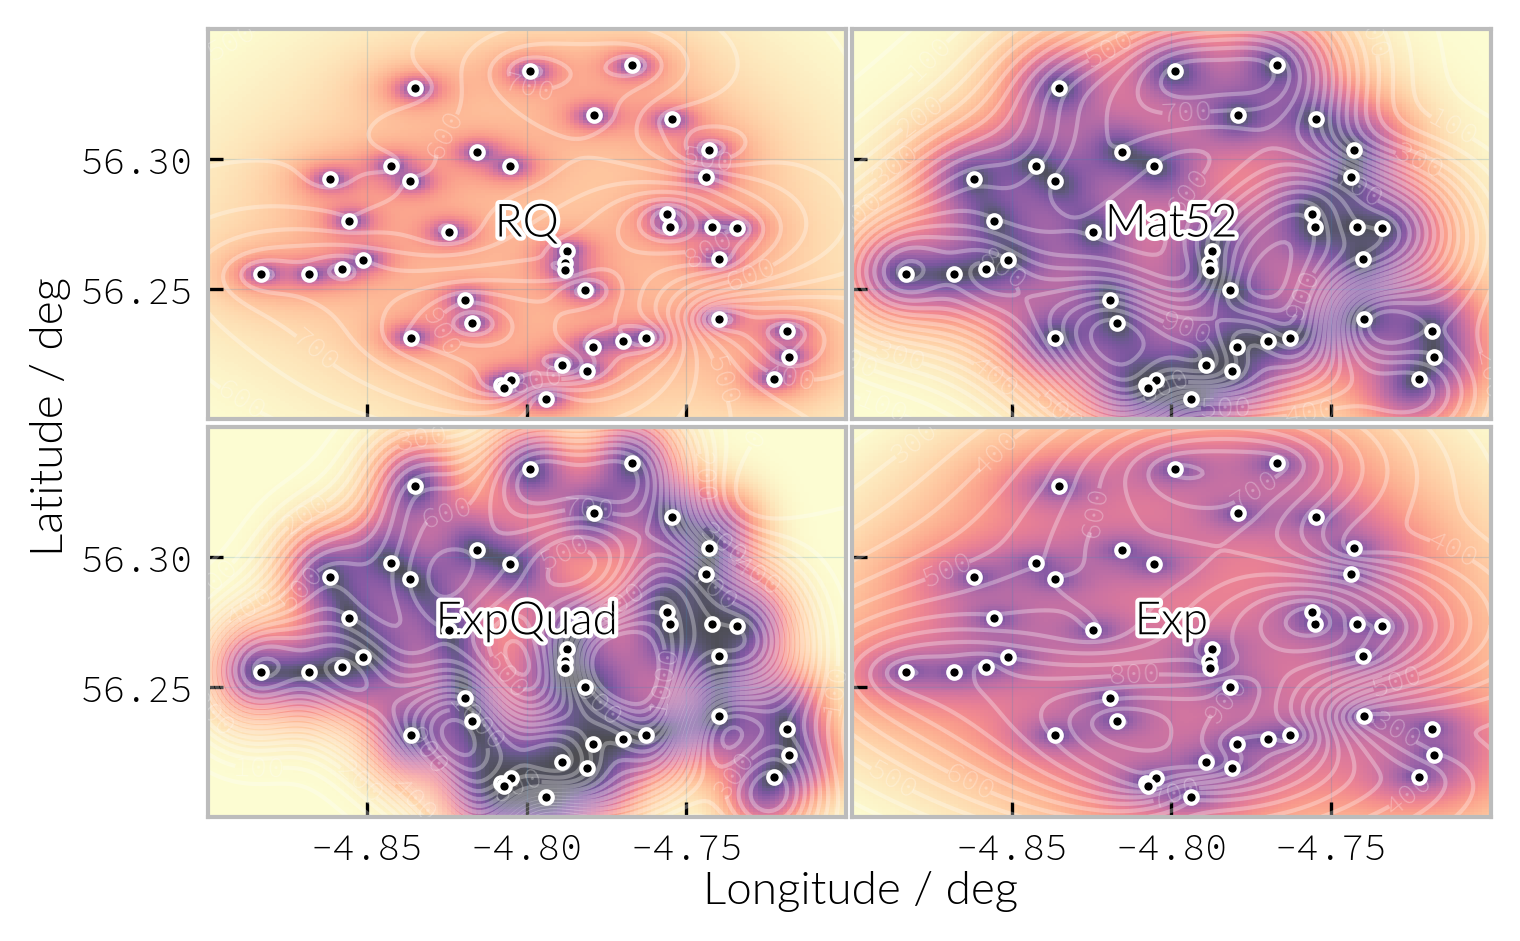

In [203]:
f, ax = plt.subplots(2,2, dpi=300, sharex=True, sharey=True);
plot_map(mu_rq, sd_rq, hills, ax=ax[0,0], min=250, contour_interval=50, label=False, plot_var=True);
text = ax[0, 0].text(-4.80, 56.275, "RQ", va="center", ha="center", fontdict=thesis.lato)
text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                               path_effects.Normal()])

plot_map(mu_mat, sd_mat, hills, ax=ax[0,1], min=50, contour_interval=50, label=False, plot_var=True);
text = ax[0, 1].text(-4.80, 56.275, "Mat52", va="center", ha="center", fontdict=thesis.lato)
text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                               path_effects.Normal()])

plot_map(mu_eq, sd_eq, hills, ax = ax[1,0], min=0, contour_interval=50, label=False, plot_var=True);
text = ax[1,0].text(-4.80, 56.275, "ExpQuad", va="center", ha="center", fontdict=thesis.lato)
text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                               path_effects.Normal()])


plot_map(mu_ex, sd_ex, hills, ax=ax[1,1], min=250, contour_interval=50, label=False, plot_var=True);
text = ax[1,1].text(-4.80, 56.275, "Exp", va="center", ha="center", fontdict=thesis.lato)
text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'),
                               path_effects.Normal()])

for axis in f.axes:
    axis.set_xticks([-4.85, -4.8,  -4.75])
    axis.set_yticks([56.25, 56.3])
    #axis.set_yticks(axis.get_yticks()[1:-1])

f.text(0.55, 0.01, 'Longitude / deg', ha='center', fontdict=thesis.lato)
f.text(0.01, 0.65, 'Latitude / deg', ha='center', rotation='vertical', fontdict=thesis.lato)    
thesis.thesisify(f);
f.subplots_adjust(wspace=0.01, hspace=0.02)

f.savefig("../../figures/gp/arrochar-kernels-var.pdf")